In [1]:
import os 
import sys
sys.path.append('/lustre/nobackup/WUR/ESG/liu297/gitrepo/VIC-WUR-GWM-1910/vic_online/python')
import flopy
import numpy as np
import xarray as xr
import netCDF4 as nc
import subprocess  # for calling shell commands
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import calendar


In [2]:

import vic_runner as vr
import support_function as sf
from config_module import config_indus_ubuntu
from osgeo import gdal
from netCDF4 import Dataset, date2num
from matplotlib import pyplot as plt

# only needed in jupyter notebook to let it know where to load the netcdf library for VIC run
%env LD_LIBRARY_PATH=/shared/legacyapps/netcdf/gcc/64/4.6.1/lib:$LD_LIBRARY_PATH   


env: LD_LIBRARY_PATH=/shared/legacyapps/netcdf/gcc/64/4.6.1/lib:$LD_LIBRARY_PATH


In [20]:
cwd = '/lustre/nobackup/WUR/ESG/liu297/gitrepo/VIC-WUR-GWM-1910/vic_online/'
config_indus_ubuntu.set_template_dir(os.path.join(cwd, 'python', 'VIC_config_file_naturalized_template_pyread_anunna.txt'))
config_indus_ubuntu.set_statefile_dir(os.path.join(cwd, 'python', 'statefile'))
config_indus_ubuntu.set_configfile_dir(os.path.join(cwd, 'python', 'configfile'))
config_indus_ubuntu.set_vic_executable('/lustre/nobackup/WUR/ESG/liu297/vic_indus/11indus_run/99vic_offline_src/drivers/image/vic_image_gwm.exe')
config_indus_ubuntu.set_startstamp(datetime(1968, 1, 1))
config_indus_ubuntu.set_mfinput_dir('/lustre/nobackup/WUR/ESG/yuan018/04Input_Indus/')
config_indus_ubuntu.set_mfoutput_dir('/lustre/nobackup/WUR/ESG/liu297/gitrepo/VIC-WUR-GWM-1910/vic_online/python/mfoutput/workspace/')
humanimpact = False

In [7]:
#%%
current_date = datetime(1968,2,1)
finishdate = datetime(1975, 12, 31)

# Loop over the dates
print("Running VIC for the time step [{}-{}]".format(current_date.year, current_date.month))
#generate dmy for VIC run
startyear, startmonth, startday = sf.startdate(current_date)
endyear, endmonth, endday = sf.enddate(current_date)
stateyear, statemonth, stateday = sf.statefiledate(current_date)
init_date,init_datestr = sf.init_datestr(current_date)

Running VIC for the time step [1968-2]


In [8]:



# prepare VIC config file
config_file = vr.prepare_vic(startyear, startmonth, startday, 
            endyear, endmonth, endday, 
            stateyear, statemonth, stateday, 
            init_date, init_datestr, 
            config_indus_ubuntu)    

vr.run_vic(config_indus_ubuntu, config_file, startyear, startmonth)    

startyear,month, day is 1968,2,1
end year, month, day is 1968,2,29
statefile wll be save for 1968,3,1


bash: module: command not found
--------------------------------------------------------------------------
By default, for Open MPI 4.0 and later, infiniband ports on a device
are not used by default.  The intent is to use UCX for these devices.
You can override this policy by setting the btl_openib_allow_ib MCA parameter
to true.

  Local host:              node263
  Local adapter:           hfi1_0
  Local port:              1

--------------------------------------------------------------------------
--------------------------------------------------------------------------

  Local host:   node263
  Local device: hfi1_0
--------------------------------------------------------------------------
[INFO] ../shared_all/src/vic_log.c:139: Logging to stderr
[DEBUG] ../shared_image/src/get_global_domain.c:98: 15167 active grid cells found in the mask of the domain file.
[WARN] ../../plugins/routing/src/rout_decomposition.c:85: errno: No such file or directory: No downstream cell was found f

VIC Driver  : Image
VIC Version : VICWUR 2.0.0 (based on VIC 5.0.1) September 2, 2019
VIC Git Tag : 
Compiled    : by liu297 on node274 (LINUX) Oct 26 2023 11:48:16
Compiler    : gcc
 version    : 11.2.0

  Variable Infiltration Capacity (VIC) macroscale hydrologic
  model version VICWUR 2.0.0, Copyright (C) 2016 Computational
  Hydrology Group, Dept. of Civil and Environmental Engineering,
  University of Washington.  VIC comes with ABSOLUTELY NO
  WARRANTY. This is free software, you may redistribute it
  under certain conditions; see LICENSE.txt for details.

  Report Bugs and Issues to : https://github.com/UW-Hydro/VIC/issues
  VIC Users Email Listserve : vic_users@u.washington.edu 

VIC-WUR run successfully for time step [1968-2]


[INFO] src/vic_image.c:185: Completed running VIC Image

------------------------------ VIC TIMING PROFILE ------------------------------

  Date                      : Tue Nov 21 10:21:07 2023
  Compiler                  : gcc (11.2.0)
  Machine                   : node263
  VIC User                  : liu297
  VIC Version               : 
  VIC GIT Version           : VICWUR 2.0.0 (based on VIC 5.0.1) September 2, 2019
  VIC_DRIVER                : Image

  Global Param File         : /lustre/nobackup/WUR/ESG/liu297/gitrepo/VIC-WUR-GWM-1910/vic_online/python/configfile/config_1968_2.txt
  Domain File               : /lustre/nobackup/WUR/ESG/liu297/vic_indus/11indus_run/05Parameters/domain_Indus.nc
  Start Date                : 1968-02-01-00000
  Stop Date                 : 1968-02-29
  Nrecs                     : 29
  Model Timestep (seconds)  : 86400
  Snow Timestep (seconds)   : 86400
  Runoff Timestep (seconds) : 3600
  Atmos Timestep (seconds)  : 86400

  MPI Processes           

### from here it is vic_postprocessing(), return recharge/discharge for mf.pre

In [11]:
output_dir = config_indus_ubuntu.output_dir
output_file = os.path.join(output_dir, f"fluxes_naturalized_gwm_.{startyear}-{startmonth:02d}.nc")

vicout = nc.Dataset(output_file)
vicout.variables.keys()

# check if there is no baseflow reported, aka, only gwrecharge is reported. 
if vicout.variables['OUT_BASEFLOW'][:,:,:].sum() == 0:
    print("baseflow is all 0")
else:
    #stop the program
    print("there is baseflow reported while GWM options == true")
    print("program will be stopped, please check the VIC configuration file")
    exit()

baseflow is all 0


In [12]:
vicout.variables.keys()

dict_keys(['time', 'time_bnds', 'lon', 'lat', 'OUT_BASEFLOW', 'OUT_RUNOFF', 'OUT_GWRECHARGE', 'OUT_SOIL_MOIST', 'OUT_WATER_ERROR', 'OUT_DISCHARGE'])

In [13]:
gwrecharge = vicout.variables['OUT_GWRECHARGE'][:,:,:] /1000 # mm/day to m/day
discharge = vicout.variables['OUT_DISCHARGE'][:,:,:]  # keep it as m3/s




### From here is mf.preprosessing(),

In [21]:
print(config_indus_ubuntu.mfinput_dir)
print(config_indus_ubuntu.mfoutput_dir)

/lustre/nobackup/WUR/ESG/yuan018/04Input_Indus/
/lustre/nobackup/WUR/ESG/liu297/gitrepo/VIC-WUR-GWM-1910/vic_online/python/mfoutput/workspace/


In [22]:

inputdir = config_indus_ubuntu.mfinput_dir
clonemap = gdal.Open(inputdir + 'Clone_05min.nc')
dem_ini = gdal.Open(inputdir + 'demfrom30s.nc').ReadAsArray()
aqdepth_ini = gdal.Open(inputdir + 'damc_ave.nc').ReadAsArray() # to define aquifer depth
ksat_log = gdal.Open(inputdir + 'lkmc_ave.nc').ReadAsArray() # to define K
cellarea = gdal.Open(inputdir + 'Indus_CellArea_m2_05min.nc').ReadAsArray() # cell of Indus
qbank = gdal.Open(inputdir+'Qbankfull_edwinInputs.nc').ReadAsArray()  
riv_slope1 =gdal.Open(inputdir+'slope05min_avgFrom30sec.nc').ReadAsArray()

Z0_floodplain = gdal.Open(inputdir+'efplact_new_05min.nc').ReadAsArray()
qaverage = gdal.Open(inputdir + 'mean_discharge_edwinInput.nc').ReadAsArray() # q of river
min_dem=gdal.Open(inputdir+'mindem_05min.nc').ReadAsArray()
KQ3 = gdal.Open(inputdir + 'Recess_NEW.nc').ReadAsArray()
conflayers = gdal.Open('/lustre/nobackup/WUR/ESG/yuan018/03DataVisual/conflayers4.nc').ReadAsArray()
conflayers = conflayers[625:805, 2951:3155]
ksat_l1_conf_log = gdal.Open(inputdir + 'kl1B_ave.nc').ReadAsArray()
ksat_l2_conf_log = gdal.Open(inputdir + 'kl2B_ave.nc').ReadAsArray()
spe_yi_inp = gdal.Open(inputdir+ 'StorCoeff_NEW.nc').ReadAsArray()
ts_gwrecharge = gdal.Open(inputdir+'gwRecharge_month_1968to2000.nc').ReadAsArray() # origin: upper-left
ts_discharge = gdal.Open(inputdir+ 'riverDischarge_month_1968to2000.nc').ReadAsArray()
nc_boundary = nc.Dataset('/lustre/nobackup/WUR/ESG/liu297/gitrepo/VIC-WUR-GWM-1910/vic_online/python/mfinput/boundary_new2.nc') #  origin: bot-left
bdmask = nc_boundary.variables['idomain'][:].data # 0 for inactive cells; 1 for boundary cells; 2 for land cells; -1 for ocean cells
#bdmask = np.flip(bdmask , axis = 0) #now origin: upper-left
topl1_gwl = nc.Dataset(inputdir + 'topl1_gwl_Indus_monthly_1968to2000.nc')
gwll1= topl1_gwl.variables['gwl'][:].data # origin: bot-left
gwll1 = np.flip(gwll1, axis = 1) # now origin: upper-left
topl2_gwl = nc.Dataset(inputdir + 'topl2_gwl_Indus_monthly_1968to2000.nc')
gwll2= topl2_gwl.variables['gwl'][:].data
gwll2 = np.flip(gwll2, axis = 1)
missingvalue = aqdepth_ini[0][0] #taking the missing value as a variable.
idomain = np.zeros_like(bdmask) # differentiate grids in calculation and not in calculation
idomain = np.copy(bdmask)
idomain = idomain.astype(int) # indus boundary - 1，inside - 2 for land, -1 for ocean，outside - 0


In [23]:

#def stress_period_data(startdate,enddate):

start_date = datetime.strptime('1968-01-01', '%Y-%m-%d')  # start date
end_date = datetime.strptime('1968-03-01', '%Y-%m-%d')  # end data
totalsp = (end_date.year - start_date.year) * 12 + end_date.month - start_date.month  # calculate stress period, in this sm: 395
month_lengths = []
sp_date = []
current_date = start_date
while current_date <= end_date:
    year = current_date.year
    month = current_date.month
    _, num_days = calendar.monthrange(year, month)
    last_day = datetime(year,month,num_days)
    month_lengths.append(num_days)
    sp_date.append(last_day.strftime('%Y-%m-%d'))
    #update to next date
    current_date = last_day + timedelta(days=1)
    
nstp = 1 # number of timesteps per stress period
tsmult = 1 # timestep multiplier
perioddata = [(days,nstp,tsmult) for days in month_lengths] #a list containing the period length for all stress period
sp = list(range(totalsp+1)) # list(396)
#return sp, sp_date, perioddata

#sp, sp_date,perioddata = stress_period_data('1968-01-01','1968-03-01') # format are all xxxx-xx-01，here is until 2000-12-31 (but write -01) TODO


In [24]:
#def dis_ic_parameter():
    #global aqdepth, topl2,Nlay,Nrow,Ncol,delrow,delcol,botm,startinghead
aqdepth = aqdepth_ini.copy()
# aqdepth[landmask==0] = 200
aqdepth[bdmask==-1] = 200
aqdepth[bdmask==-2] = 200
aqdepth[aqdepth==missingvalue] = 200
aqdepth = np.where(aqdepth >0, aqdepth , 200)
# dem = np.where(landmask==1, dem_ini, 0)
# 创建一个与 bdmask 形状相同的掩码数组，用于检查条件
mask_1 = (bdmask == 1)
mask_2 = (bdmask == 2)

# 使用 logical_or 同时检查两个条件
combined_mask = np.logical_or(mask_1, mask_2)

# 根据条件选择对应元素
dem = np.where(combined_mask, dem_ini, 0)

# dem = np.where(dem_ini==missingvalue, dem_ini, 0)
topl2 = dem
topl2 = np.where(topl2==missingvalue, 0 ,topl2) 
botl2 = topl1 = topl2-(aqdepth*0.1) #second layer is 10% total thickness
botl2 = np.where(botl2==missingvalue, -20 ,botl2)
topl1 = np.where(topl1==missingvalue, -20 ,topl1)
botl1 = topl2-aqdepth
botl1 = np.where(botl1==missingvalue, -200 ,botl1)
    
botm = [botl2,botl1]        
Nlay = 2
# Nrow, Ncol = landmask.shape
Nrow, Ncol = bdmask.shape
#global delrow, delcol
delrow = clonemap.GetGeoTransform()[1]*111*1000
delcol = abs(clonemap.GetGeoTransform()[5]*111*1000)
    #return Nlay,Nrow,Ncol,delrow,delcol,topl2,botm

In [25]:
#def initial_head():
startingheadl2 = gwll2[0].copy()  #top layer #indus case: run steady-state model first, then use the computed head as the starting head for stress period 0
startingheadl1 = gwll2[0].copy()  #bot layer 
initial_head = [startingheadl2,startingheadl1]
#    return initial_head

#lay,Nrow,Ncol,delrow,delcol,topl2,botm = dis_ic_parameter()

In [26]:
#def npf_parameter():
    #global aqdepth,delcol,delrow,spe_yi_inp
rho_water,miu_water,g_gravity = 1000,0.001,9.81
dikte_l2_ini = aqdepth *0.1  #top layer
dikte_l1_ini = aqdepth -dikte_l2_ini  #bottom layer
dikte_l2= dikte_l2_ini.copy() 
# dikte_l2[landmask ==0] = missingvalue
dikte_l2[bdmask == -1] = missingvalue
dikte_l2[bdmask == -2] = missingvalue
dikte_l1 = dikte_l1_ini.copy()
# dikte_l1[landmask == 0] = missingvalue
dikte_l1[bdmask == -1] = missingvalue
dikte_l1[bdmask == -2] = missingvalue
conflayers[conflayers !=1 ]  = 0 
#k for no confining layer area:
ksat_inp = rho_water * (10 ** ksat_log) * (g_gravity / miu_water) * 24.0 * 3600.0
# k for confining layer area:
ksat_l1_conf=rho_water* (10**ksat_l1_conf_log)* (g_gravity/ miu_water) *24.0 *3600.0# fine grained
ksat_l2_conf=rho_water* (10**ksat_l2_conf_log)* (g_gravity/ miu_water) *24.0 *3600.0# coarse grained
khoriz_l1_ini = np.where(ksat_l1_conf != 0, ksat_l1_conf, ksat_inp)
khoriz_l2_ini =	np.where(ksat_l2_conf != 0, ksat_l2_conf, ksat_inp)
khoriz_l1_ini = np.clip(khoriz_l1_ini,a_min = 0.01, a_max = None)
khoriz_l2_ini = np.clip(khoriz_l2_ini,a_min = 0.01, a_max = None)
#k vertical
kvert_l2_ini = np.where(khoriz_l2_ini >-999,khoriz_l2_ini*cellarea/(delcol*delrow), (10.0*cellarea/(delcol*delrow)))
kvert_l1 = np.where(khoriz_l1_ini>-999, (10.0*cellarea/(delcol*delrow)),(10.0*cellarea/(delcol*delrow)))
kvert_l2 = np.maximum(dikte_l2/5000,kvert_l2_ini)
kd_l2_ini = khoriz_l2_ini*(dikte_l2)
kd_l1_ini = khoriz_l1_ini*(dikte_l1)	
kd_l2 = np.maximum(30,kd_l2_ini)
kd_l1 = np.maximum(30,kd_l1_ini)
khoriz_l2 = kd_l2/dikte_l2
khoriz_l1 = kd_l1/dikte_l1
khoriz_l2[khoriz_l2<0]  = 20
khoriz_l1[khoriz_l1<0]  = 190
kvert_l2[kvert_l2<0] = 1e10
kvert_l2[kvert_l2<0] = 1e10
k_hor = [khoriz_l2, khoriz_l1]
k_ver = [khoriz_l2*0.1,khoriz_l1*0.1]
# Storage Coefficient
spe_yi_inp = spe_yi_inp
# spe_yi_inp = np.where(landmask ==1, spe_yi_inp,missingvalue)
spe_yi_inp = np.where(bdmask >=1, spe_yi_inp,missingvalue)
spe_yi_inp = np.maximum(0.01,spe_yi_inp)
spe_yi_inp = np.minimum(1,spe_yi_inp)
spe_yi_inp = np.where(aqdepth >-999.9,np.maximum(spe_yi_inp, 0.11),spe_yi_inp)
stor_prim = spe_yi_inp
stor_sec = spe_yi_inp
stor=[stor_prim,stor_prim]
#    return k_hor,k_ver,stor


In [27]:
# RCH package
#def rch_input(monthly_recharge):
rch_nat = ts_gwrecharge[0]
# input changes with time
rcmissingvalue = rch_nat[-1][0]
# rch_nat[landmask ==1 & (rch_nat==rcmissingvalue)]= 0
recharge_inp = ((rch_nat/(1000*365)*cellarea)/(delcol*delrow))
recharge_inp = np.where(recharge_inp <10000, recharge_inp, 0)
npzero = np.zeros_like(recharge_inp)
# recharge on the top layer    
recharge_inp = np.maximum(recharge_inp,npzero)
recharge_inp[idomain == -1]=np.nan
recharge_inp[idomain == 0 ]=np.nan
recharge_inp[idomain == -2]=0
nrow, ncol = recharge_inp.shape
cellids = [(0, i, j) for i in range(nrow) for j in range(ncol)]
# Create stress_period_data as a list of lists (leave it for mf6)
RCHstress_period_data = []
for cellid, value, bdmask_ind in zip(cellids, recharge_inp.flatten(), bdmask.flatten()):
    if np.isnan(value) or value ==0 or bdmask_ind == 0 or bdmask_ind == -1:
    # if np.isnan(value) or value ==0:
        continue
    cellid_1, cellid_2, cellid_3 = cellid
    RCHstress_period_data.append([cellid_1, cellid_2, cellid_3, value])

    #return RCHstress_period_data


In [28]:

#def riv_input(monthly_discharge,qaverage):
qaverage = qbank # 
monthly_discharge = ts_discharge[0] 
riv_manning,resistance,riv_bedres_inp = 0.045,1.0,1.0000
min_dem2 = np.where(min_dem<0,0,min_dem)


Z0_floodplain1 = np.maximum(min_dem2, Z0_floodplain)
Z0_floodplain2 = np.where(Z0_floodplain < 0.0, Z0_floodplain1, Z0_floodplain)
riv_width = 4.8* ((qaverage)**0.5)
riv_width = np.maximum(riv_width, 0.5)


riv_slope = np.where(riv_width > 0.0, riv_slope1,missingvalue)
riv_slope_used = np.where(riv_slope>0.00005, riv_slope,missingvalue)
riv_head_ini = np.where(riv_width > 30.0, Z0_floodplain2, topl2)
riv_head_ini[bdmask==-1] = 0    
riv_head_ini[bdmask==-2] = 0   

riv_depth_bkfl = 	((riv_manning*(qaverage)**0.5)/(riv_width*riv_slope_used**0.5))**(3.0/5.0)
riv_depth_bkfl = np.where(np.isnan(riv_depth_bkfl),missingvalue,riv_depth_bkfl)
riv_bot_bkfl = min_dem2 - riv_depth_bkfl

riv_depth_avg1 = ((riv_manning*((monthly_discharge)**0.5))/(riv_width*riv_slope_used**0.5))**(3.0/5.0) #  
riv_depth_avg = np.where(riv_depth_avg1 < 0.01, 0.0, riv_depth_avg1)
riv_depth_avg = np.where(np.isnan(riv_depth_avg),0,riv_depth_avg)
riv_head=riv_bot_bkfl + riv_depth_avg
riv_head2 = np.where(np.isnan(riv_head), riv_head_ini, riv_head)
riv_head2 = np.where(riv_head == -1*missingvalue, riv_head_ini, riv_head)
denominator = np.where(riv_width >= 30.0, riv_width * (cellarea*2.0) ** 0.5, 0.0)
riv_cond =  1 / resistance * denominator
riv_cond[bdmask == -1]=0
drn_width1 = np.maximum(10,riv_width)
drn_width = np.where(riv_cond == 0.0, drn_width1, 0.0)
drn_cond = np.where(riv_cond ==0, (1.0/resistance)*drn_width*(cellarea*2)**0.5,0.0)
drn_cond = np.where(drn_cond<1e-20, 0,drn_cond)
riv_head_comb = np.where(riv_cond > 0.0, riv_head2, riv_head_ini)
riv_head_comb = np.where(np.isnan(riv_head_comb),0,riv_head_comb)
riv_head_comb[bdmask==-1]=np.nan
riv_head_comb[bdmask==-2]=np.nan
riv_bot_comb = np.where(riv_cond >0.0, riv_bot_bkfl,riv_head_ini)
riv_bot_comb[np.isinf(riv_bot_comb)] = 0
riv_bot_comb = np.where(riv_bot_comb == -missingvalue, np.nan, riv_bot_comb)
riv_bot_comb[bdmask==-1]=np.nan
riv_bot_comb[bdmask==0]=np.nan
riv_bot_comb[bdmask==-2]=np.nan
riv_cond_comb = np.where(riv_cond>0, riv_cond, drn_cond)
riv_cond_comb[bdmask==-1]=np.nan
riv_cond_comb[bdmask==0]=np.nan
riv_cond_comb[bdmask==-2]=np.nan


nrow, ncol = bdmask.shape
cellids = [(0, i, j) for i in range(nrow) for j in range(ncol)]
RIVstress_period_data = []
for cellid, stage, rbot, cond, bdmask_ind in zip(cellids, riv_head_comb.flatten(), riv_bot_comb.flatten(), riv_cond_comb.flatten(), bdmask.flatten()): 
    # Skip cellids with NaN values in stage or rbot
    if np.isnan(stage) or np.isnan(rbot) or np.isnan(cond) or cond == 0 or bdmask_ind !=2:
    # if np.isnan(stage) or np.isnan(rbot) or np.isnan(cond) or cond == 0:
        continue
    cellid_1, cellid_2, cellid_3 = cellid
    RIVstress_period_data.append([cellid_1, cellid_2, cellid_3, stage, cond, rbot])
#return RIVstress_period_data


In [29]:
#CHD package
#def chd_input(stress_period):
CHDstress_period_data = []
# first layer (top layer)
nrow, ncol = bdmask.shape
cellids = [(0, i, j) for i in range(nrow) for j in range(ncol)] # 创建一个包含元组的列表，每个元组包含三个值：0、i 和 j
for cellid, id_num in zip(cellids, idomain.flatten()):
    cellid_1, cellid_2, cellid_3 = cellid
    if id_num != 1 and id_num != 4: 
        continue
    if id_num == 4:
        gwll2[0][cellid_2][cellid_3] = 0
    if np.isnan(gwll2[0][cellid_2][cellid_3]):
        gwll2[0][cellid_2][cellid_3] = 0
    CHDstress_period_data.append([cellid_1, cellid_2, cellid_3, gwll2[0][cellid_2][cellid_3]]) # cellid_1 is layer number: 0 for top, 1 for bot
# second layer (bot layer)
nrow, ncol = bdmask.shape
cellids = [(1, i, j) for i in range(nrow) for j in range(ncol)]
for cellid, id_num in zip(cellids, idomain.flatten()):
    cellid_1, cellid_2, cellid_3 = cellid
    if id_num != 1 and id_num != 4:
        continue
    if id_num == 4:
        gwll1[0][cellid_2][cellid_3] = 0
    if np.isnan(gwll1[0][cellid_2][cellid_3]):
        gwll1[0][cellid_2][cellid_3] = 0
    CHDstress_period_data.append([cellid_1, cellid_2, cellid_3, gwll1[0][cellid_2][cellid_3]]) # cellid_1 is layer number: 0 for top, 1 for bot
    #return CHDstress_period_data # list of list: 


In [35]:
layer2_head = {} # top
layer1_head = {} # bot
for stress_period,date in zip(sp, sp_date):
    if (stress_period==0):
        print('assign steady-state computed head as the starting head for stress period 0')
        startinghead = initial_head
    else:
        startingheadl2 = layer2_head[stress_period-1]
        startingheadl1 = layer1_head[stress_period-1]
        startinghead = [startingheadl2,startingheadl2]
        print(f"start assigning the variables for stress period {stress_period}...\n")
    #Nlay,Nrow,Ncol,delrow,delcol,topl2,botm = dis_ic_parameter()
    #k_hor,k_ver,stor = npf_parameter()
    #RCHstress_period_data = rch_input(ts_gwrecharge[stress_period])
    #RIVstress_period_data = riv_input(ts_discharge[stress_period],qbank)
    #CHDstress_period_data = chd_input(stress_period)
    idomain1 = [idomain,idomain]
    name = '2Ltrans_off'
    print('finish assigning variables \n')
    print(f"writing the flopy variables for stress period {stress_period}...\n")
    sim = flopy.mf6.MFSimulation(
        sim_name=name,version='mf6', sim_ws=config_indus_ubuntu.mfoutput_dir, 
        exe_name = config_indus_ubuntu.mf6exe,
        verbosity_level = 1, continue_ = False, nocheck = True,
        memory_print_option = None, write_headers = True)
    tdis = flopy.mf6.ModflowTdis(
        sim,time_units= "DAYS", start_date_time = None,nper= 1,                     
        perioddata= [(perioddata[stress_period][0],perioddata[stress_period][1],perioddata[stress_period][2])]
        )
    rclose = 1000
    ims = flopy.mf6.ModflowIms(
        sim, complexity='COMPLEX', print_option="SUMMARY",
            outer_dvclose=50, inner_dvclose=50, under_relaxation="simple",
            under_relaxation_gamma=0.9, relaxation_factor=0,
            linear_acceleration="bicgstab", outer_maximum = 100, 
            inner_maximum = 500, rcloserecord="{} strict".format(rclose) )
    model_nam_file = f"{name}.nam"   
    gwf = flopy.mf6.ModflowGwf(
        sim, modelname = name, model_nam_file = model_nam_file,
        exe_name = config_indus_ubuntu.mf6exe, model_rel_path = '.', list= None,
        print_input = False, print_flows = False, save_flows = True)
    dis = flopy.mf6.ModflowGwfdis(
        gwf,length_units = "METERS",nogrb = True, xorigin = 0,yorigin = 0,
        angrot = 0,nlay=Nlay, nrow=Nrow, ncol=Ncol,
        idomain = idomain1, delr=delrow,delc=delcol,top=topl2, botm=botm)
    npf = flopy.mf6.ModflowGwfnpf(
        gwf, save_flows = False, print_flows = False, save_specific_discharge =False,
        save_saturation = False, perioddata = None, dev_no_newton = False,
        icelltype = 0,  k = k_hor, k33 = k_ver)
    sto = flopy.mf6.ModflowGwfsto(
        gwf, save_flows=None, storagecoefficient=True, 
        ss_confined_only=None, iconvert=0,ss=stor, #steady_state=None,
        transient=True)
    chd = flopy.mf6.ModflowGwfchd(
        gwf,  print_input = False, print_flows = False, save_flows = True,
        stress_period_data=CHDstress_period_data)
    ic = flopy.mf6.ModflowGwfic(
        gwf, strt = startinghead)
    rch = flopy.mf6.ModflowGwfrch(
        gwf,stress_period_data=RCHstress_period_data)
    riv = flopy.mf6.ModflowGwfriv(
        gwf,stress_period_data= RIVstress_period_data)
    saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
    printrecord = [("HEAD", "ALL")]
    headfile = "{}_{}.hds".format(name,date)
    head_filerecord = [headfile]
    budgetfile = "{}_{}.cbb".format(name,date)
    budget_filerecord = [budgetfile]
    
    oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(
        gwf,saverecord=saverecord,head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord)
    print('finish writing the flopy variables \n')
    print(f"writing the simulation for stress period {stress_period}...\n")
    sim.write_simulation()
    print('finish writing the simulation \n')
    print(f"running the simulation for stress period {stress_period}...\n")
    success, buff = sim.run_simulation()
    if not success:
        raise Exception(f"MODFLOW 6 did not terminate normally for stressperiod: {stress_period}\n")
    else:
        print(f"MODFLOW 6 terminated normally for stressperiod: {stress_period}\n")
        print(f"extracting the head and budget files for stress period {stress_period}...\n")
        head = flopy.utils.binaryfile.HeadFile(config_indus_ubuntu.mfoutput_dir+headfile)
        layer2_head[stress_period] = head.get_data()[0]
        layer1_head[stress_period] = head.get_data()[1]

assign steady-state computed head as the starting head for stress period 0
finish assigning variables 

writing the flopy variables for stress period 0...

finish writing the flopy variables 

writing the simulation for stress period 0...

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model 2Ltrans_off...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package sto...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 1586 based on size of stress_period_data
    writing package ic...
    writing package rch_0...
INFORMATION: maxbound in ('gwf6', 'rch', 'dimensions') changed to 7151 based on size of stress_period_data
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 14470 based on size of stress_period_data
    writing package oc...
finish writing the simulat

## do some ploting to check mf input

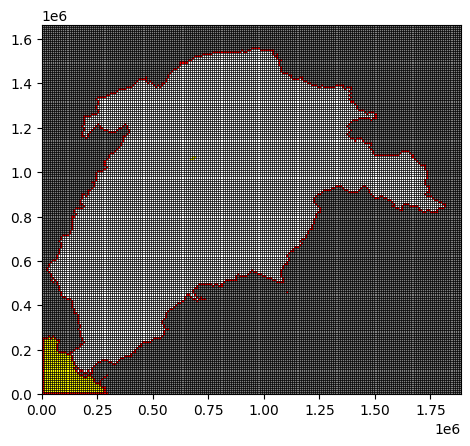

In [31]:
pmv = flopy.plot.PlotMapView(model=gwf, layer=1)

pmv.plot_bc('chd', color='red')
#pmv.plot_array(khoriz_l2)
#quadmesh = pmv.plot_array(gwll1)
#pmv.plot_inactive(color_noflow='gray')
pmv.plot_ibound(color_noflow='gray', color_ch='blue',color_vpt='yellow')
#quadmesh = pmv.plot_bc('RIV', color='blue')
pmv.plot_grid(lw=0.5, color='black')


#plt.colorbar(quadmesh, shrink=0.5)
plt.show()

In [32]:
# Assuming recharge_inp is your masked array
non_nan_max = np.nanmax(recharge_inp)
non_nan_min = np.nanmin(recharge_inp)

print("Max:", non_nan_max)
print("Min:", non_nan_min)
print(rch_nat[-1][0])
print(rch_nat[0][0])

#check how many grids in bdmask are 1
bdmask_1 = np.where(bdmask == 1, 1, 0)
# count how many 1 in bdmask_1
bdmask_1.sum()

print(len(CHDstress_period_data))

Max: 1.0129244805021965e-07
Min: 0.0
1e+20
3.9113558e-05
1586


19813.28


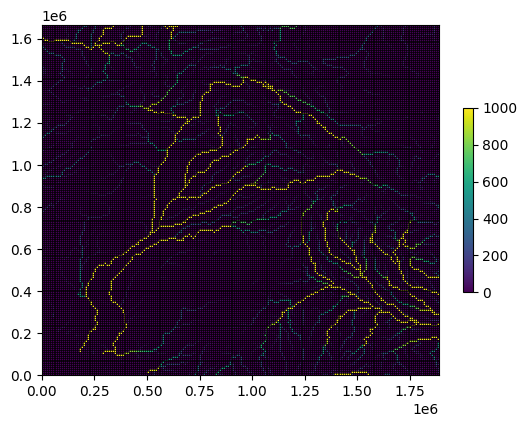

In [40]:
hds = gwf.output.head()
head = hds.get_data()[1]
pmv = flopy.plot.PlotMapView(model=gwf, layer=0)

print(qbank.max())

#pmv.plot_bc('chd', color='red')
quadmesh=pmv.plot_array(qbank,vmin = 0, vmax = 1000)

#quadmesh = pmv.plot_array(riv_head_comb)

#pmv.plot_inactive(color_noflow='gray')
#pmv.plot_ibound(color_noflow='gray', color_ch='blue',color_vpt='red')
#quadmesh = pmv.plot_bc('RIV', color='blue')
pmv.plot_grid(lw=0.5, color='black')


plt.colorbar(quadmesh, shrink=0.5)
# set  min amd max of colorbar


plt.show()